In [78]:
# -*- coding: utf-8 -*-
"""
Attention_RNN_on_Test_Data.py
"""

import os
import time
import random
import csv

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1) Download & register Noto Sans Bengali (for plotting later)
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansBengali/NotoSansBengali-Regular.ttf \
    -O /usr/share/fonts/truetype/NotoSansBengali-Regular.ttf
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/NotoSansBengali-Regular.ttf')

# 2) Configure Matplotlib font stack
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Noto Sans Bengali', 'DejaVu Sans']

# -------------------
# --- Vocab & Data ---
# -------------------
class CharVocab:
    def __init__(self, filepaths):
        self.rom_char2idx = {}
        self.dev_char2idx = {}
        self.rom_idx2char = {}
        self.dev_idx2char = {}
        self._build_vocab(filepaths)

    def _build_vocab(self, filepaths):
        rom_chars, dev_chars = set(), set()
        for fp in filepaths:
            with open(fp, "r", encoding="utf-8") as f:
                reader = csv.reader(f, delimiter="\t")
                for row in reader:
                    if len(row) < 2:
                        continue
                    dev, rom = row[0].strip(), row[1].strip()
                    if dev and rom:
                        rom_chars.update(rom)
                        dev_chars.update(dev)
        PAD, SOS, EOS = "<pad>", "<sos>", "<eos>"
        all_rom = [PAD, SOS, EOS] + sorted(rom_chars)
        all_dev = [PAD, SOS, EOS] + sorted(dev_chars)
        for i, ch in enumerate(all_rom):
            self.rom_char2idx[ch] = i
            self.rom_idx2char[i] = ch
        for i, ch in enumerate(all_dev):
            self.dev_char2idx[ch] = i
            self.dev_idx2char[i] = ch

        # store special indices
        self.rom_pad_idx = self.rom_char2idx[PAD]
        self.rom_sos_idx = self.rom_char2idx[SOS]
        self.rom_eos_idx = self.rom_char2idx[EOS]
        self.dev_pad_idx = self.dev_char2idx[PAD]
        self.dev_sos_idx = self.dev_char2idx[SOS]
        self.dev_eos_idx = self.dev_char2idx[EOS]

    @property
    def rom_vocab_size(self):
        return len(self.rom_char2idx)

    @property
    def dev_vocab_size(self):
        return len(self.dev_char2idx)

    def roman_to_indices(self, s):
        return [self.rom_sos_idx] + [
            self.rom_char2idx.get(ch, self.rom_pad_idx) for ch in s
        ] + [self.rom_eos_idx]

    def dev_to_indices(self, s):
        return [self.dev_sos_idx] + [
            self.dev_char2idx.get(ch, self.dev_pad_idx) for ch in s
        ] + [self.dev_eos_idx]

    def indices_to_dev(self, idxs):
        return "".join(
            self.dev_idx2char[i]
            for i in idxs
            if i not in (self.dev_sos_idx, self.dev_eos_idx, self.dev_pad_idx)
        )


def read_tsv(path):
    pairs = []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if len(row) < 2:
                continue
            dev, rom = row[0].strip(), row[1].strip()
            if dev and rom:
                pairs.append((rom, dev))
    return pairs

class TransliterationDataset(Dataset):
    def __init__(self, filepath, vocab):
        self.pairs = read_tsv(filepath)
        self.vocab = vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rom, dev = self.pairs[idx]
        return (
            torch.tensor(self.vocab.roman_to_indices(rom), dtype=torch.long),
            torch.tensor(self.vocab.dev_to_indices(dev), dtype=torch.long),
        )

    @staticmethod
    def collate_fn(batch):
        roms, devs = zip(*batch)
        max_r, max_d = max(map(len, roms)), max(map(len, devs))
        rom_patches, dev_patches = [], []
        for r, d in zip(roms, devs):
            pad_r = torch.cat([r, r.new_full((max_r - len(r),), 0)])
            pad_d = torch.cat([d, d.new_full((max_d - len(d),), 0)])
            rom_patches.append(pad_r)
            dev_patches.append(pad_d)
        return torch.stack(rom_patches), torch.stack(dev_patches)

# -----------------------
# --- Attention Module ---
# -----------------------
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden[-1]: (batch, H)
        h = hidden[-1]
        seq_len = encoder_outputs.size(1)
        h_expanded = h.unsqueeze(1).repeat(1, seq_len, 1)  # (B, T, H)
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(h_expanded)))  # (B, T, 1)
        attention_weights = torch.softmax(score.squeeze(2), dim=1)  # (B, T)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (B, H)
        return context, attention_weights

# -----------------------
# --- Model (Encoder) ---
# -----------------------
class Encoder(nn.Module):
    def __init__(self, inp_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(inp_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[self.cell]
        self.rnn = rnn_cls(
            emb_sz,
            hid_sz,
            num_layers=nl,
            batch_first=True,
            dropout=do if nl > 1 else 0.0,
        )
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, x):
        emb = self.embed(x)
        if self.cell == "LSTM":
            outputs, (h, c) = self.rnn(emb)
            return outputs, (h, c)
        else:
            outputs, h = self.rnn(emb)
            return outputs, h

# -----------------------
# --- Model (Decoder) ---
# -----------------------
class Decoder(nn.Module):
    def __init__(self, out_sz, emb_sz, hid_sz, nl, cell, do):
        super().__init__()
        self.embed = nn.Embedding(out_sz, emb_sz, padding_idx=0)
        self.cell = cell.upper()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[self.cell]
        self.rnn = rnn_cls(
            emb_sz + hid_sz,
            hid_sz,
            num_layers=nl,
            batch_first=True,
            dropout=do if nl > 1 else 0.0,
        )
        self.attention = BahdanauAttention(hid_sz)
        self.out = nn.Linear(hid_sz, out_sz)
        self.hidden_size, self.num_layers = hid_sz, nl

    def forward(self, tgt, hidden, cell, encoder_outputs, teacher_forcing_ratio=0.0):
        B, T = tgt.size()
        outputs = torch.zeros(B, T, self.out.out_features, device=tgt.device)
        input_step = tgt[:, 0]
        h, c = (hidden, cell) if self.cell == "LSTM" else (hidden, None)
        for t in range(1, T):
            emb = self.embed(input_step)  # (B, emb)
            context, _ = self.attention(h, encoder_outputs)  # (B, H)
            rnn_input = torch.cat([emb, context], dim=1).unsqueeze(1)  # (B,1, emb+H)
            if self.cell == "LSTM":
                out, (h, c) = self.rnn(rnn_input, (h, c))
            else:
                out, h = self.rnn(rnn_input, h)
                c = None
            logits = self.out(out.squeeze(1))  # (B, vocab)
            outputs[:, t] = logits
            teacher_force = random.random() < teacher_forcing_ratio
            next_input = tgt[:, t] if teacher_force else logits.argmax(1)
            input_step = next_input
        return outputs

# -------------------------------------
# --- Seq2Seq Wrapper ---
# -------------------------------------
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, device):
        super().__init__()
        self.encoder = enc
        self.decoder = dec
        self.device = device

    def forward(self, src, tgt, tf_ratio=0.5):
        if self.encoder.cell == "LSTM":
            enc_outputs, (h_n, c_n) = self.encoder(src)
        else:
            enc_outputs, h_n = self.encoder(src)
            c_n = None
        enc_layers = self.encoder.num_layers
        dec_layers = self.decoder.num_layers
        H = self.encoder.hidden_size
        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]
                c_dec = c_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, src.size(0), H, device=self.device)
                pad_c = torch.zeros(dec_layers - enc_layers, src.size(0), H, device=self.device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
                c_dec = torch.cat([pad_c, c_n], dim=0)
        else:
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, src.size(0), H, device=self.device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
            c_dec = None
        logits = self.decoder(tgt, h_dec, c_dec, enc_outputs, teacher_forcing_ratio=tf_ratio)
        return logits

    @torch.no_grad()
    def batch_greedy_decode(self, src_batch, max_len, sos, eos, heatmap_indices, idx_offset=0):
        """
        src_batch: (B, src_len)
        Returns:
          list of pred sequences (list of token lists),
          attention weights dict mapping global index to list of (timestep-attention arrays)
        """
        B, src_len = src_batch.size()
        device = self.device
        # Encode batch
        if self.encoder.cell == "LSTM":
            enc_outputs, (h_n, c_n) = self.encoder(src_batch)
        else:
            enc_outputs, h_n = self.encoder(src_batch)
            c_n = None
        enc_layers = self.encoder.num_layers
        dec_layers = self.decoder.num_layers
        H = self.encoder.hidden_size
        # Prepare initial decoder hidden/cell
        if self.encoder.cell == "LSTM":
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]  # (L_dec, B, H)
                c_dec = c_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, B, H, device=device)
                pad_c = torch.zeros(dec_layers - enc_layers, B, H, device=device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
                c_dec = torch.cat([pad_c, c_n], dim=0)
        else:
            if enc_layers >= dec_layers:
                h_dec = h_n[-dec_layers:]
            else:
                pad_h = torch.zeros(dec_layers - enc_layers, B, H, device=device)
                h_dec = torch.cat([pad_h, h_n], dim=0)
            c_dec = None
        # Initialize sequences, attention containers, done mask
        seqs = [[sos] for _ in range(B)]
        done = [False] * B
        attentions = {idx_offset + i: [] for i in range(B) if (idx_offset + i) in heatmap_indices}
        # Current input tokens
        current_tokens = torch.tensor([sos] * B, device=device)  # (B,)
        for _ in range(max_len):
            emb = self.decoder.embed(current_tokens).squeeze(1)  # (B, emb)
            context, attn_weights = self.decoder.attention(h_dec, enc_outputs)  # (B, H), (B, src_len)
            # Store attention for those in heatmap_indices
            for i in range(B):
                global_idx = idx_offset + i
                if global_idx in heatmap_indices and not done[i]:
                    attentions[global_idx].append(attn_weights[i].cpu().numpy())
            rnn_input = torch.cat([emb, context], dim=1).unsqueeze(1)  # (B,1, emb+H)
            if self.decoder.cell == "LSTM":
                out, (h_dec, c_dec) = self.decoder.rnn(rnn_input, (h_dec, c_dec))
            else:
                out, h_dec = self.decoder.rnn(rnn_input, h_dec)
            logits = self.decoder.out(out.squeeze(1))  # (B, vocab)
            next_tokens = logits.argmax(1)  # (B,)
            for i in range(B):
                if not done[i]:
                    token = next_tokens[i].item()
                    seqs[i].append(token)
                    if token == eos:
                        done[i] = True
            current_tokens = next_tokens
            if all(done):
                break
        return seqs, attentions


Sample ID: 2804
Source (Roman): choudharyshoho
Prediction (Bengali): চৌধারিহস
True Target (Bengali): চৌধুরীসহ
----------------------------------------

--- Full Attention Heatmap ---


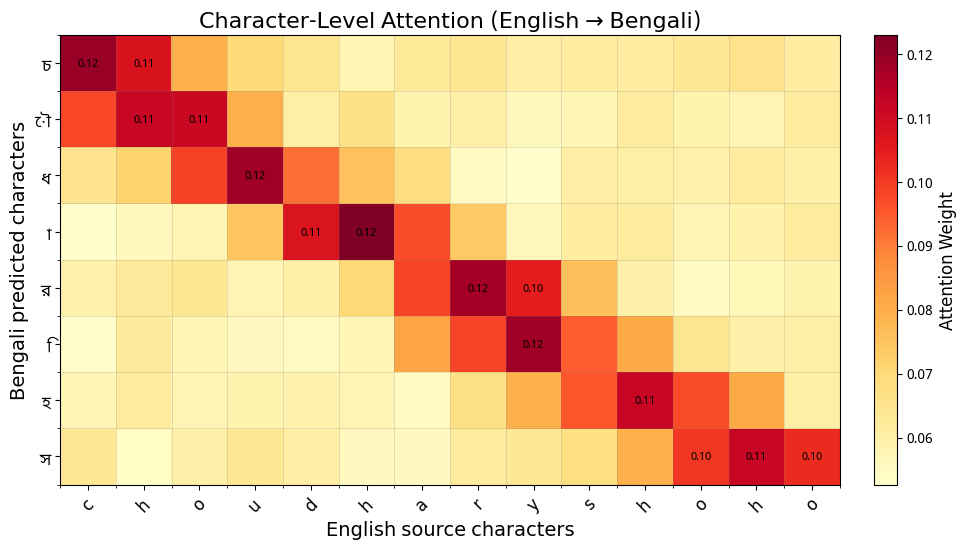


--- Attention Summary ---
Output 'চ' → Highest attention on 'c' (0.119)
Output 'ৌ' → Highest attention on 'h' (0.112)
Output 'ধ' → Highest attention on 'u' (0.118)
Output 'া' → Highest attention on 'h' (0.123)
Output 'র' → Highest attention on 'r' (0.117)
Output 'ি' → Highest attention on 'y' (0.118)
Output 'হ' → Highest attention on 'h' (0.112)
Output 'স' → Highest attention on 'h' (0.112)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


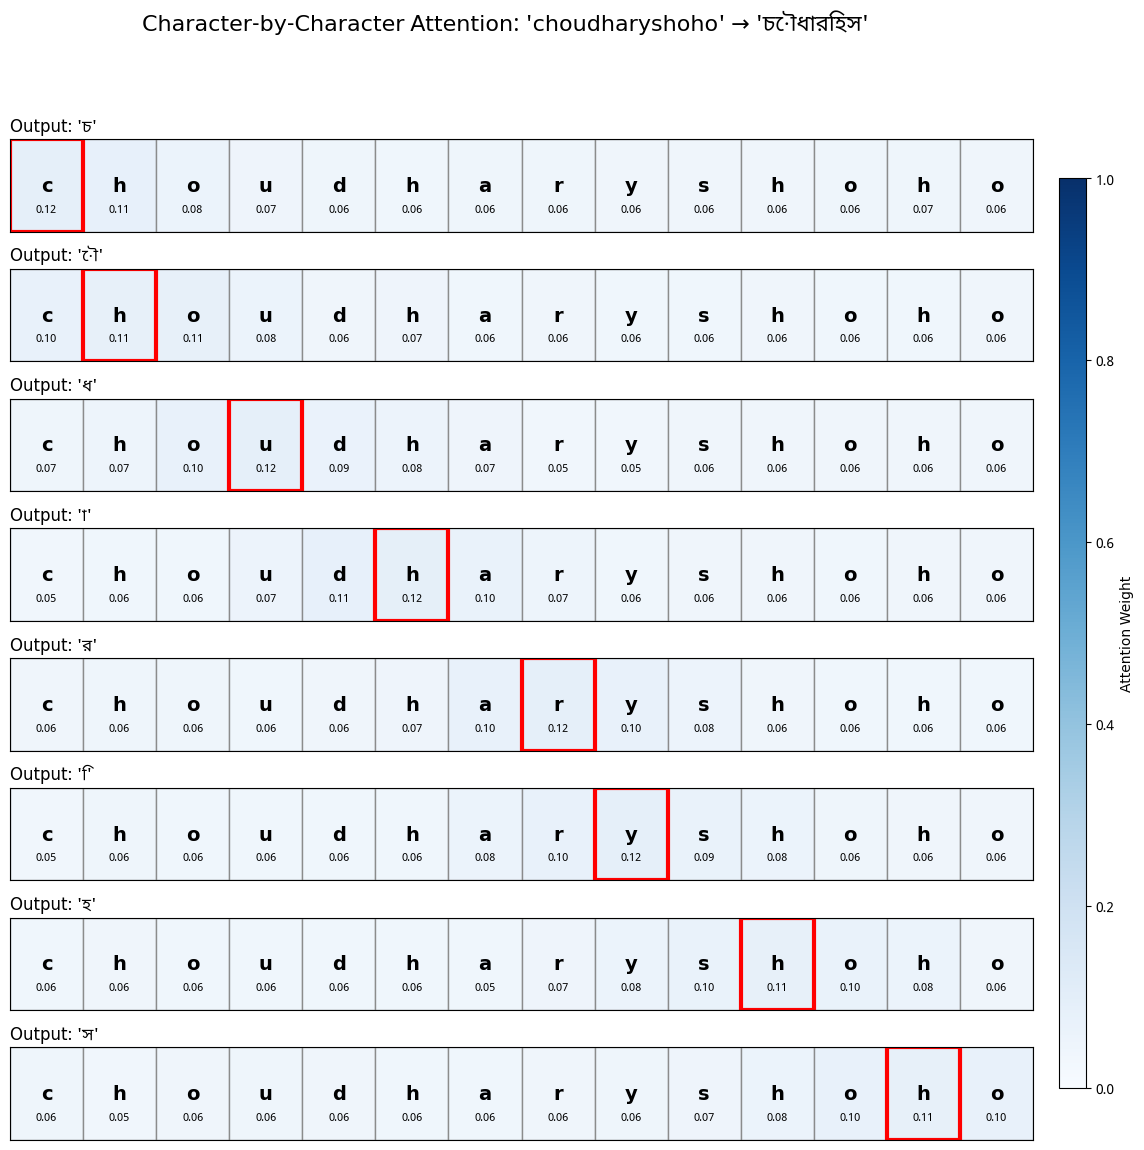


Sample ID: 8991
Source (Roman): hajar
Prediction (Bengali): হজজার
True Target (Bengali): হাজার
----------------------------------------

--- Full Attention Heatmap ---


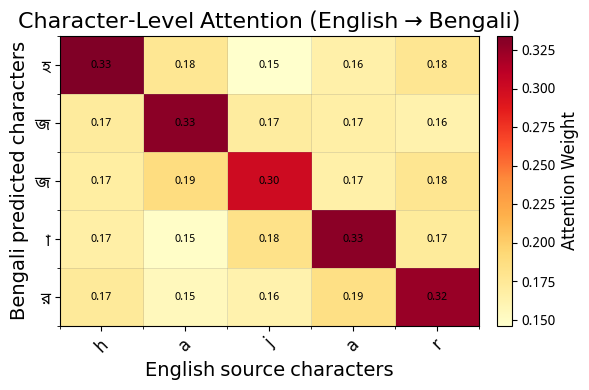


--- Attention Summary ---
Output 'হ' → Highest attention on 'h' (0.334)
Output 'জ' → Highest attention on 'a' (0.329)
Output 'জ' → Highest attention on 'j' (0.300)
Output 'া' → Highest attention on 'a' (0.329)
Output 'র' → Highest attention on 'r' (0.324)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


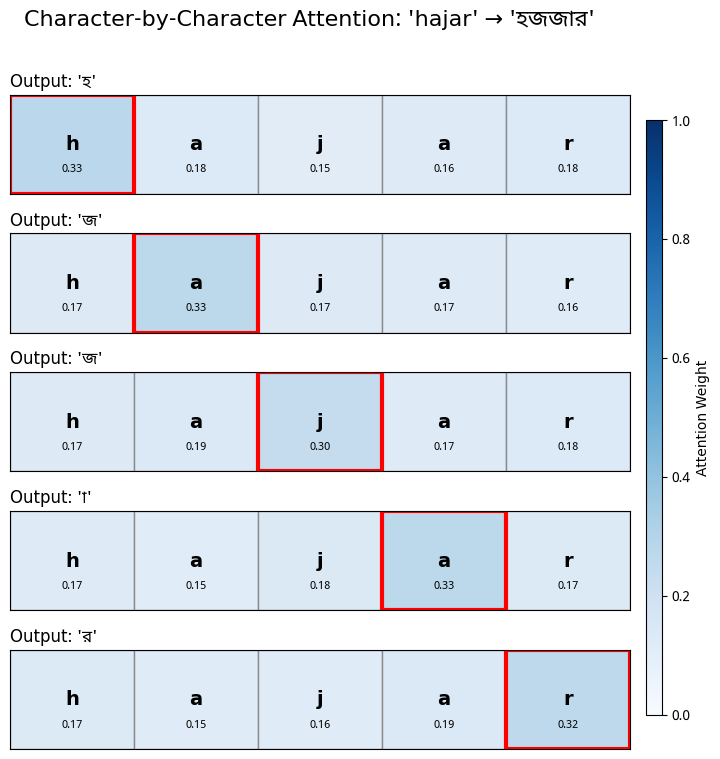


Sample ID: 5498
Source (Roman): bongobondhur
Prediction (Bengali): বঙ্গবন্ধুর
True Target (Bengali): বঙ্গবন্ধুর
----------------------------------------

--- Full Attention Heatmap ---


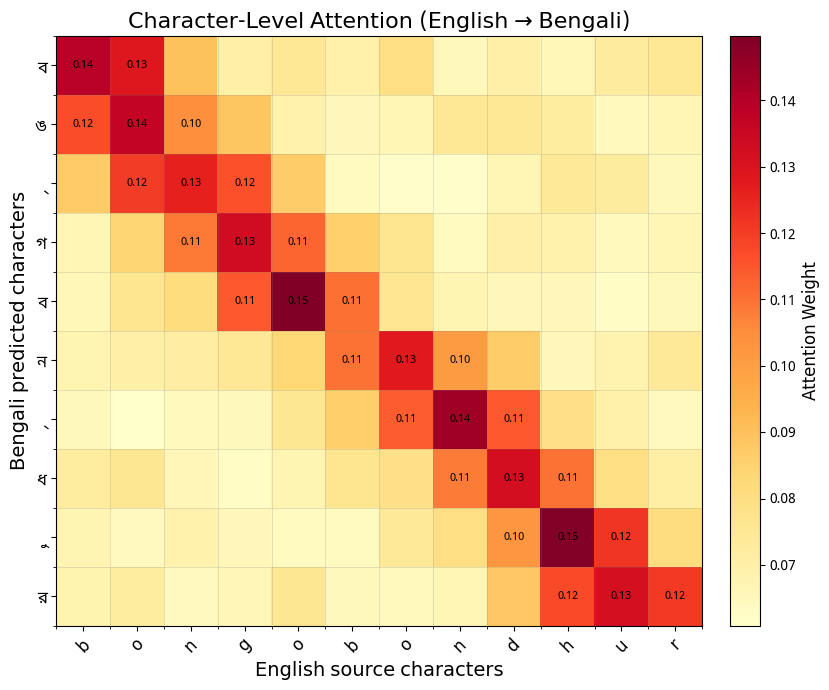


--- Attention Summary ---
Output 'ব' → Highest attention on 'b' (0.139)
Output 'ঙ' → Highest attention on 'o' (0.136)
Output '্' → Highest attention on 'n' (0.126)
Output 'গ' → Highest attention on 'g' (0.133)
Output 'ব' → Highest attention on 'o' (0.150)
Output 'ন' → Highest attention on 'o' (0.128)
Output '্' → Highest attention on 'n' (0.144)
Output 'ধ' → Highest attention on 'd' (0.132)
Output 'ু' → Highest attention on 'h' (0.149)
Output 'র' → Highest attention on 'u' (0.132)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


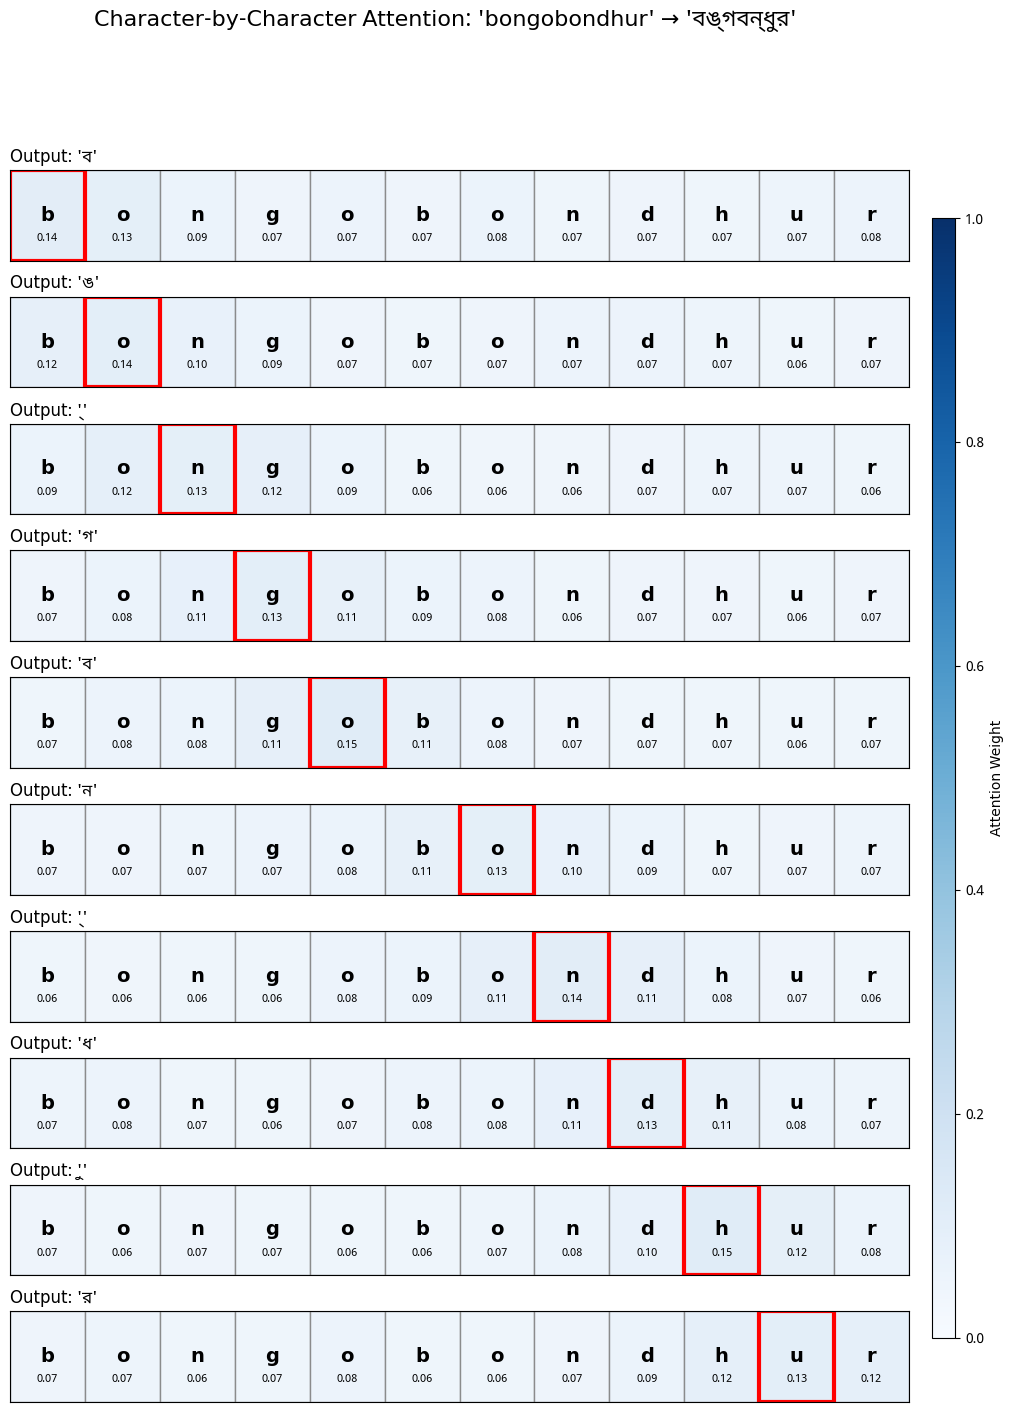


Sample ID: 9048
Source (Roman): harmees
Prediction (Bengali): হার্মিস
True Target (Bengali): হার্মিস
----------------------------------------

--- Full Attention Heatmap ---


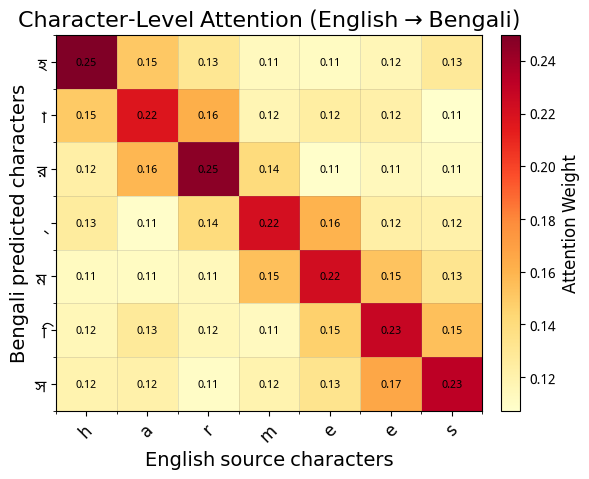


--- Attention Summary ---
Output 'হ' → Highest attention on 'h' (0.250)
Output 'া' → Highest attention on 'a' (0.217)
Output 'র' → Highest attention on 'r' (0.246)
Output '্' → Highest attention on 'm' (0.221)
Output 'ম' → Highest attention on 'e' (0.223)
Output 'ি' → Highest attention on 'e' (0.227)
Output 'স' → Highest attention on 's' (0.232)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


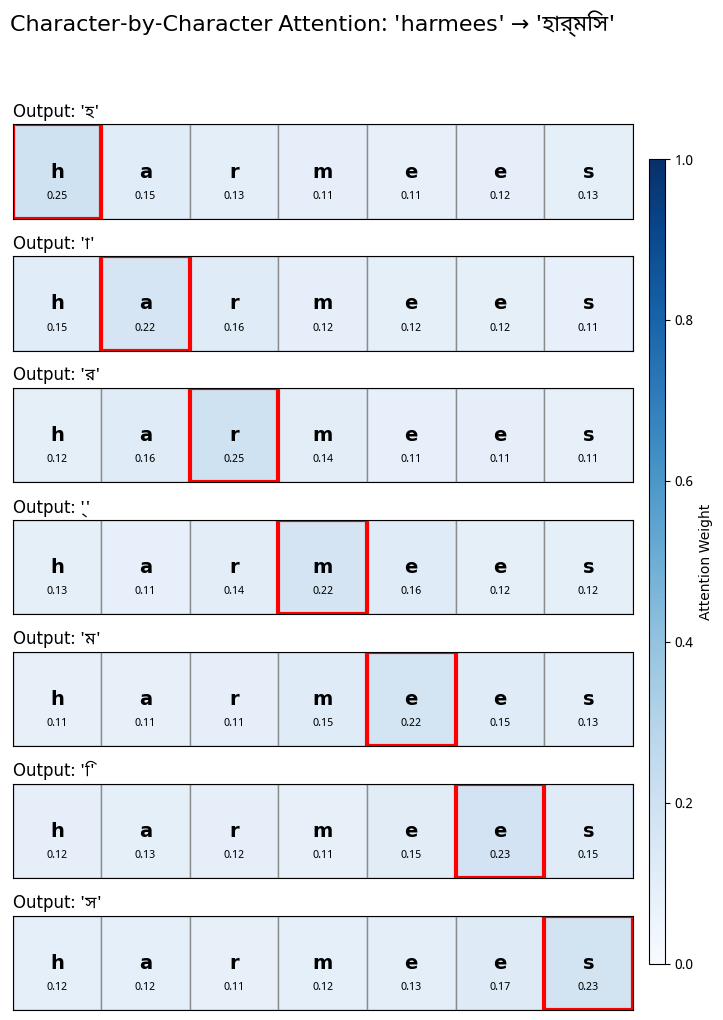


Sample ID: 1231
Source (Roman): utkontha
Prediction (Bengali): উৎকণ্ঠ
True Target (Bengali): উৎকণ্ঠা
----------------------------------------

--- Full Attention Heatmap ---


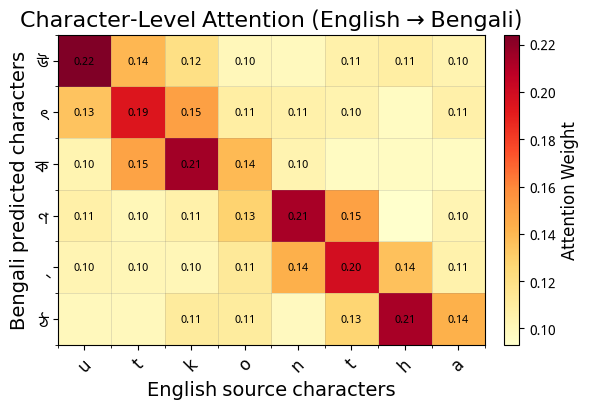


--- Attention Summary ---
Output 'উ' → Highest attention on 'u' (0.224)
Output 'ৎ' → Highest attention on 't' (0.194)
Output 'ক' → Highest attention on 'k' (0.215)
Output 'ণ' → Highest attention on 'n' (0.213)
Output '্' → Highest attention on 't' (0.199)
Output 'ঠ' → Highest attention on 'h' (0.213)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


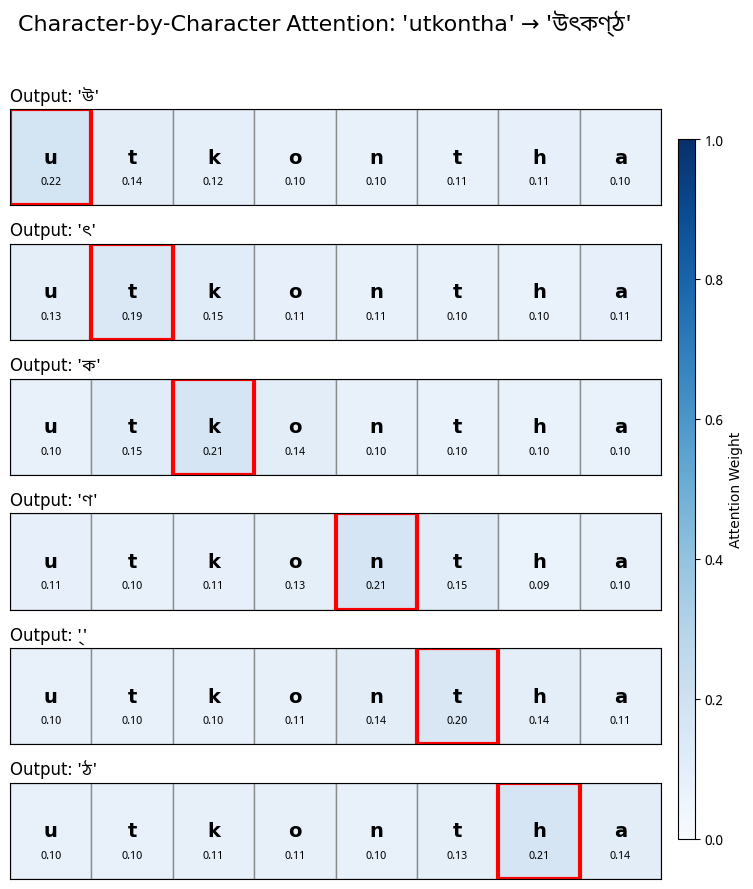


Sample ID: 4514
Source (Roman): noirajjo
Prediction (Bengali): নৈরাজ্য
True Target (Bengali): নৈরাজ্য
----------------------------------------

--- Full Attention Heatmap ---


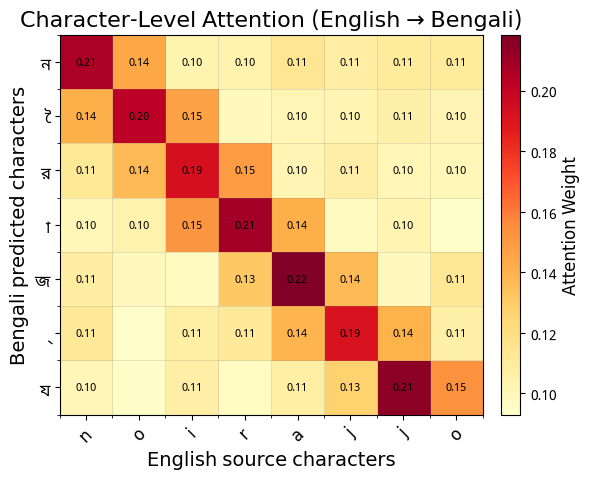


--- Attention Summary ---
Output 'ন' → Highest attention on 'n' (0.207)
Output 'ৈ' → Highest attention on 'o' (0.203)
Output 'র' → Highest attention on 'i' (0.193)
Output 'া' → Highest attention on 'r' (0.209)
Output 'জ' → Highest attention on 'a' (0.219)
Output '্' → Highest attention on 'j' (0.192)
Output 'য' → Highest attention on 'j' (0.215)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


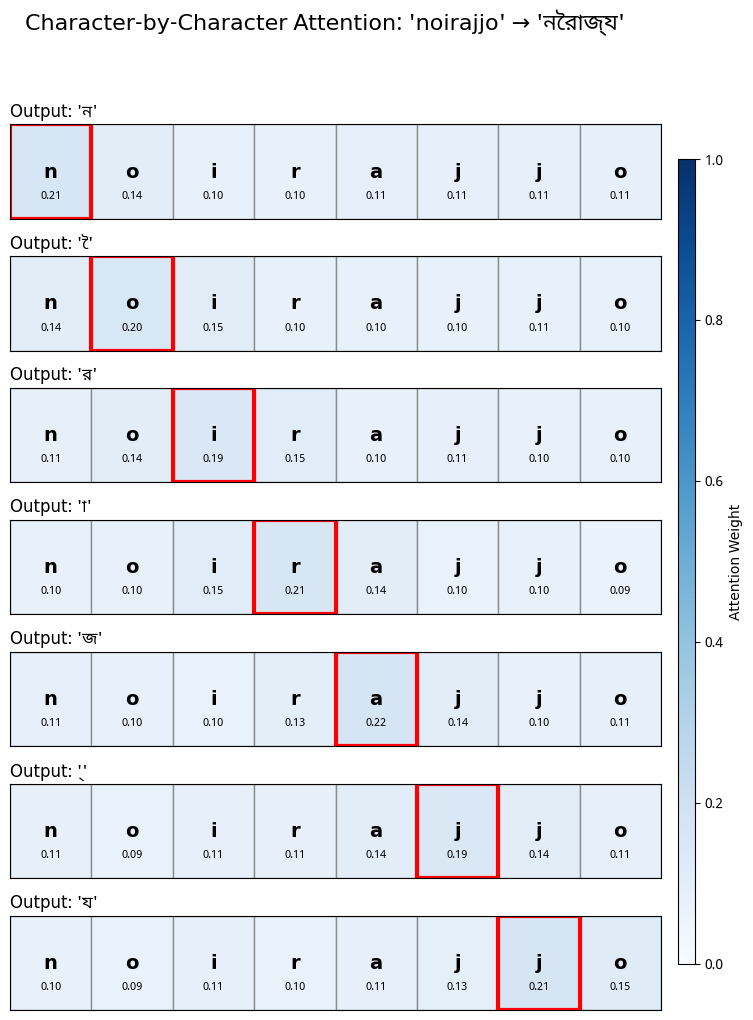


Sample ID: 860
Source (Roman): arthar
Prediction (Bengali): আর্থার
True Target (Bengali): আর্থার
----------------------------------------

--- Full Attention Heatmap ---


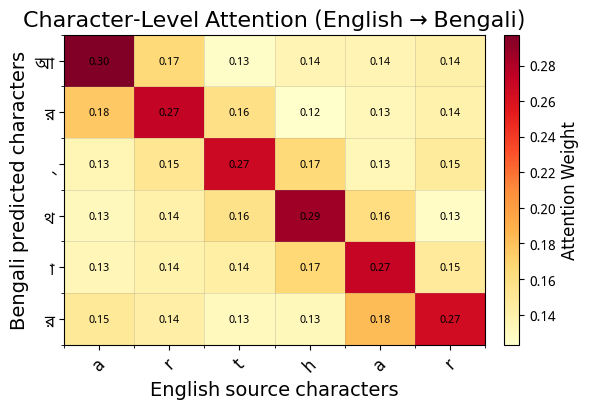


--- Attention Summary ---
Output 'আ' → Highest attention on 'a' (0.297)
Output 'র' → Highest attention on 'r' (0.272)
Output '্' → Highest attention on 't' (0.267)
Output 'থ' → Highest attention on 'h' (0.286)
Output 'া' → Highest attention on 'a' (0.270)
Output 'র' → Highest attention on 'r' (0.265)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


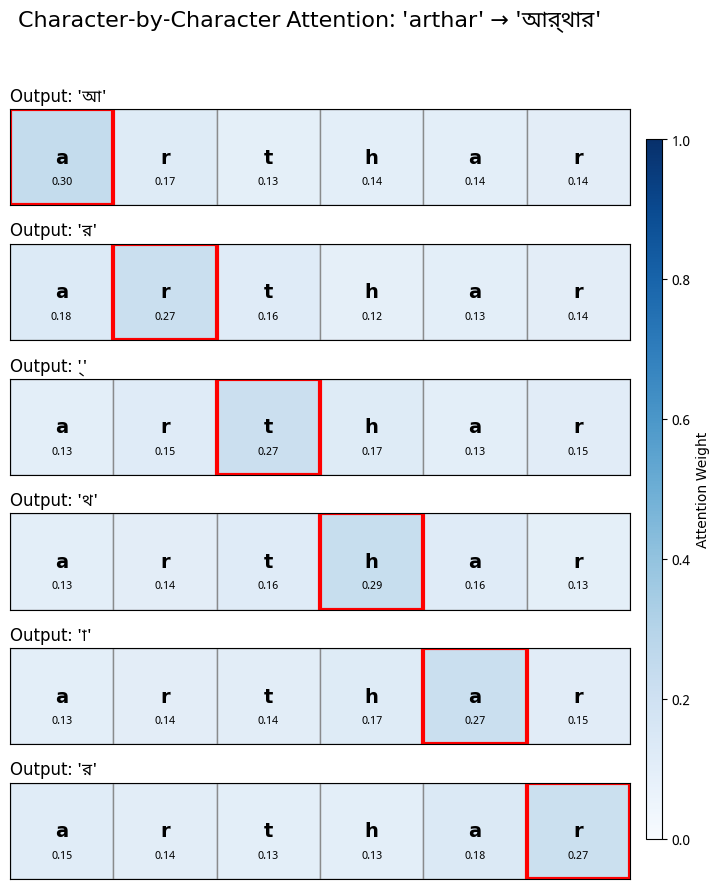


Sample ID: 8456
Source (Roman): sinar
Prediction (Bengali): সিনার
True Target (Bengali): সিনার
----------------------------------------

--- Full Attention Heatmap ---


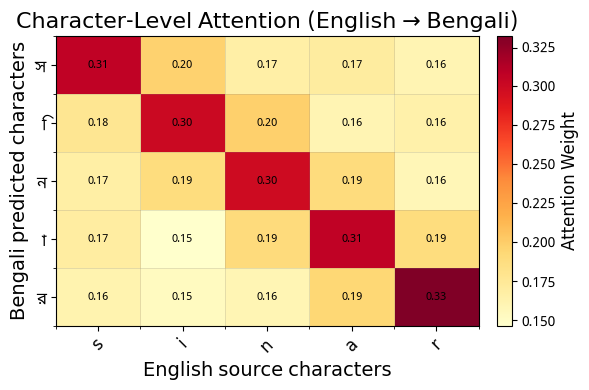


--- Attention Summary ---
Output 'স' → Highest attention on 's' (0.306)
Output 'ি' → Highest attention on 'i' (0.301)
Output 'ন' → Highest attention on 'n' (0.299)
Output 'া' → Highest attention on 'a' (0.307)
Output 'র' → Highest attention on 'r' (0.333)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


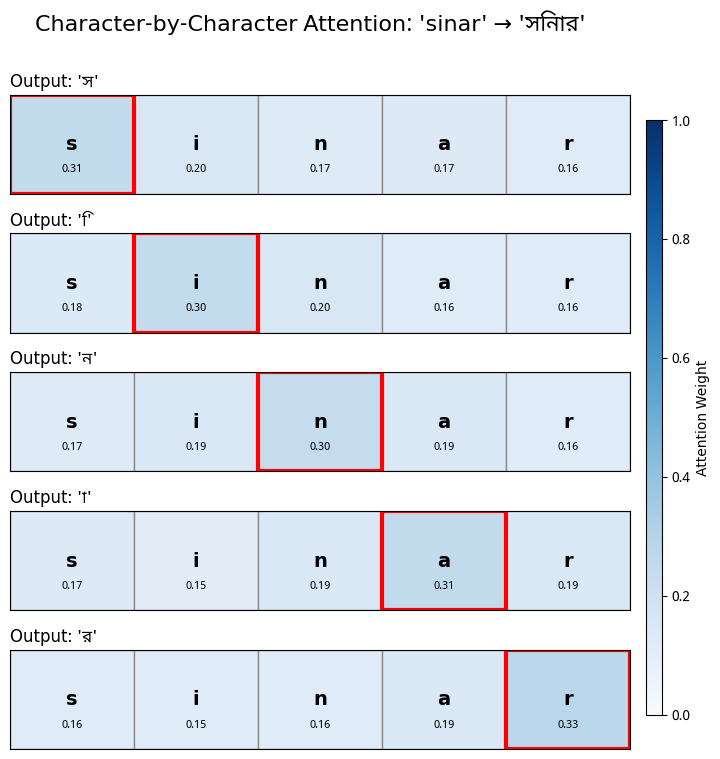


Sample ID: 7164
Source (Roman): ranatori
Prediction (Bengali): রানারির
True Target (Bengali): রণতরী
----------------------------------------

--- Full Attention Heatmap ---


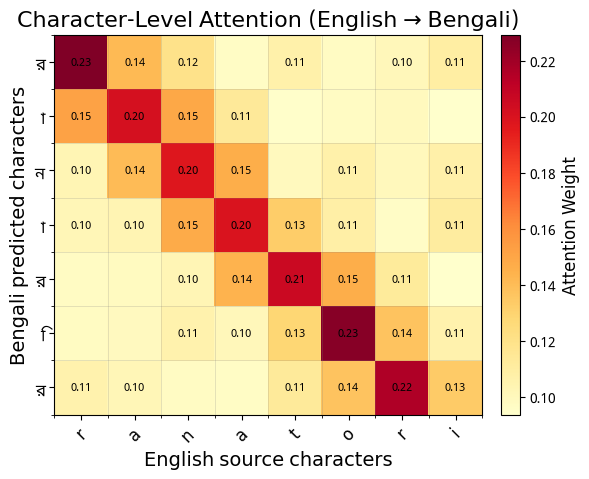


--- Attention Summary ---
Output 'র' → Highest attention on 'r' (0.229)
Output 'া' → Highest attention on 'a' (0.201)
Output 'ন' → Highest attention on 'n' (0.198)
Output 'া' → Highest attention on 'a' (0.200)
Output 'র' → Highest attention on 't' (0.206)
Output 'ি' → Highest attention on 'o' (0.227)
Output 'র' → Highest attention on 'r' (0.216)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


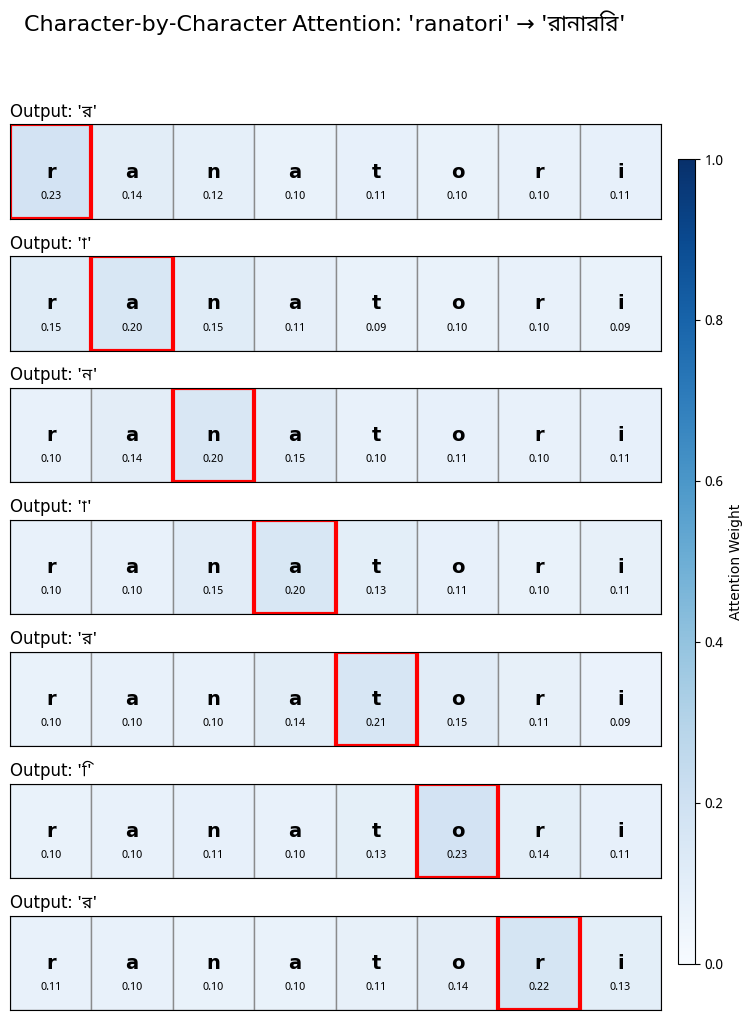


Sample ID: 5733
Source (Roman): baaraaker
Prediction (Bengali): বারাকের
True Target (Bengali): বারাকের
----------------------------------------

--- Full Attention Heatmap ---


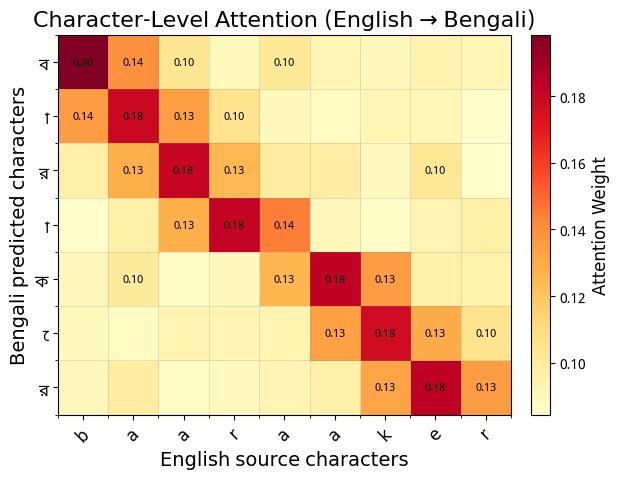


--- Attention Summary ---
Output 'ব' → Highest attention on 'b' (0.198)
Output 'া' → Highest attention on 'a' (0.179)
Output 'র' → Highest attention on 'a' (0.181)
Output 'া' → Highest attention on 'r' (0.181)
Output 'ক' → Highest attention on 'a' (0.183)
Output 'ে' → Highest attention on 'k' (0.177)
Output 'র' → Highest attention on 'e' (0.183)

--- Character-by-Character Attention Visualization ---


<ipython-input-87-981b63836056>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


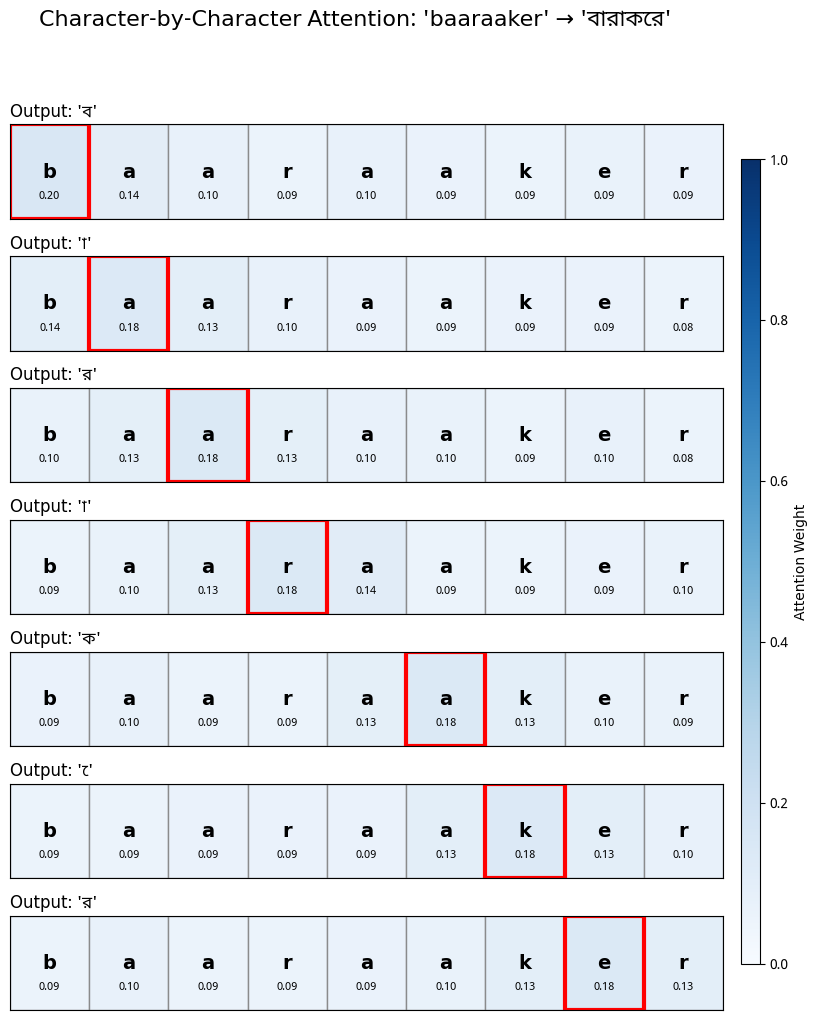

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, clear_output
import time

def plot_char_by_char_attention(src_chars, pred_chars, attn_matrix):
    """
    Create a visual plot for character-by-character attention.

    Args:
        src_chars: List of source characters
        pred_chars: List of predicted target characters
        attn_matrix: Tensor of attention weights [tgt_len, src_len]
    """
    valid_tgt_len = len(pred_chars)
    valid_src_len = len(src_chars)

    # Take only the necessary portions of the attention matrix
    valid_attn = attn_matrix[:valid_tgt_len, :valid_src_len].numpy()

    # Set up the figure
    fig_height = valid_tgt_len * 1.5 + 1
    fig_width = max(8, valid_src_len * 0.8 + 2)
    fig, axs = plt.subplots(valid_tgt_len, 1, figsize=(fig_width, fig_height),
                           gridspec_kw={'hspace': 0.4})

    # Adjust for single character output case
    if valid_tgt_len == 1:
        axs = [axs]

    # Define a better colormap for attention visualization
    colors = [
        '#f7fbff', '#e3eef9', '#cfe1f2', '#b5d4e9', '#93c3df',
        '#6daed5', '#4b97c9', '#2f7ebc', '#1864aa', '#0a4a90', '#08306b'
    ]
    cmap = LinearSegmentedColormap.from_list('attention_cmap', colors)

    # Plot each target character's attention separately
    for i, (ax, tgt_char) in enumerate(zip(axs, pred_chars)):
        # Get attention weights for this character
        attn_weights = valid_attn[i]

        # Create color rectangles for each source character
        for j, src_char in enumerate(src_chars):
            weight = attn_weights[j]
            rect = patches.Rectangle(
                (j, 0), 1, 1,
                linewidth=1,
                edgecolor='gray',
                facecolor=cmap(weight),
                alpha=0.8
            )
            ax.add_patch(rect)

            # Add text for character and weight
            text_color = 'black' if weight < 0.7 else 'white'
            ax.text(j + 0.5, 0.5, src_char, ha='center', va='center', fontsize=14,
                   color=text_color, weight='bold')
            ax.text(j + 0.5, 0.25, f'{weight:.2f}', ha='center', va='center',
                   fontsize=8, color=text_color)

        # Set axis limits and title
        ax.set_xlim(0, valid_src_len)
        ax.set_ylim(0, 1)
        ax.set_title(f"Output: '{tgt_char}'", fontsize=12, loc='left')
        ax.set_yticks([])
        ax.set_xticks([])

        # Highlight the max attention
        max_idx = np.argmax(attn_weights)
        highlight = patches.Rectangle(
            (max_idx, 0), 1, 1,
            linewidth=3,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(highlight)

    # Add a colorbar on the right
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Attention Weight')

    # Add overall title and labels
    fig.suptitle(f"Character-by-Character Attention: '{''.join(src_chars)}' → '{''.join(pred_chars)}'",
                fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

# Update the main visualization function to use the new plotting function
# Modified function that combines both original and new visualizations
def run_combined_attention_visualization(sample_ids, test_dataset, vocab, model):
    """Visualize attention for selected samples with both original and improved visuals."""
    for idx in sample_ids:
        # Get source tensor and true target
        src_tensor, tgt_tensor = test_dataset[idx]

        # Extract raw character sequences, properly filtering special tokens
        src_raw_ids = src_tensor.tolist()
        src_chars = [vocab.rom_idx2char[i] for i in src_raw_ids
                    if i not in (vocab.rom_pad_idx, vocab.rom_sos_idx, vocab.rom_eos_idx)]

        # Get model predictions and attention
        pred_ids, attn_matrix = get_prediction_and_attention(src_tensor.unsqueeze(0).to(device))

        # Convert prediction indices to characters
        pred_chars = [vocab.dev_idx2char[i] for i in pred_ids
                     if i not in (vocab.dev_pad_idx, vocab.dev_sos_idx, vocab.dev_eos_idx)]

        # Get true target characters for comparison
        tgt_raw_ids = tgt_tensor.tolist()
        true_chars = [vocab.dev_idx2char[i] for i in tgt_raw_ids
                     if i not in (vocab.dev_pad_idx, vocab.dev_sos_idx, vocab.dev_eos_idx)]

        # Print sample information
        print(f"\n{'='*40}")
        print(f"Sample ID: {idx}")
        print(f"Source (Roman): {''.join(src_chars)}")
        print(f"Prediction (Bengali): {''.join(pred_chars)}")
        print(f"True Target (Bengali): {''.join(true_chars)}")
        print(f"{'-'*40}")

        # 1. Plot original full heatmap (keeping this from original code)
        print("\n--- Full Attention Heatmap ---")
        plot_char_attention(src_chars, pred_chars, attn_matrix)

        # 2. Print attention summary (keeping this from original code)
        print("\n--- Attention Summary ---")
        valid_attn = attn_matrix[:len(pred_chars), :len(src_chars)]

        for step, tgt_char in enumerate(pred_chars):
            if step < valid_attn.shape[0]:
                row = valid_attn[step].numpy()
                max_idx = row.argmax()
                max_val = row[max_idx]
                print(f"Output '{tgt_char}' → Highest attention on '{src_chars[max_idx]}' ({max_val:.3f})")

        # 3. Add the new character-by-character visualization
        print("\n--- Character-by-Character Attention Visualization ---")
        plot_char_by_char_attention(src_chars, pred_chars, attn_matrix)

# Run the visualization with 5 random samples
if __name__ == "__main__":
    total_samples = len(test_dataset)
    sample_ids = random.sample(range(total_samples), k=10)
    run_combined_attention_visualization(sample_ids, test_dataset, vocab, model)